In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
train=pd.read_csv("train.csv")
test=pd.read_csv("test.csv")

In [3]:
train['source']='train'
test['source']='test'
data=pd.concat([train,test],ignore_index=True)
print (train.shape,test.shape,data.shape)

(8523, 13) (5681, 12) (14204, 13)


In [4]:
data.apply(lambda x:sum(x.isnull()))

Item_Fat_Content                0
Item_Identifier                 0
Item_MRP                        0
Item_Outlet_Sales            5681
Item_Type                       0
Item_Visibility                 0
Item_Weight                  2439
Outlet_Establishment_Year       0
Outlet_Identifier               0
Outlet_Location_Type            0
Outlet_Size                  4016
Outlet_Type                     0
source                          0
dtype: int64

In [5]:
data.describe()

,Item_MRP,Item_Outlet_Sales,Item_Visibility,Item_Weight,Outlet_Establishment_Year
count,14204.000000,8523.000000,14204.000000,11765.000000,14204.000000
mean,141.004977,2181.288914,0.065953,12.792854,1997.830681
std,62.086938,1706.499616,0.051459,4.652502,8.371664
min,31.290000,33.290000,0.000000,4.555000,1985.000000
25%,94.012000,834.247400,0.027036,8.710000,1987.000000
50%,142.247000,1794.331000,0.054021,12.600000,1999.000000
75%,185.855600,3101.296400,0.094037,16.750000,2004.000000
max,266.888400,13086.964800,0.328391,21.350000,2009.000000


In [6]:
data.apply(lambda x:len(x.unique()))

Item_Fat_Content                 5
Item_Identifier               1559
Item_MRP                      8052
Item_Outlet_Sales             3494
Item_Type                       16
Item_Visibility              13006
Item_Weight                    416
Outlet_Establishment_Year        9
Outlet_Identifier               10
Outlet_Location_Type             3
Outlet_Size                      4
Outlet_Type                      4
source                           2
dtype: int64

In [7]:
categorical_columns=[x for x in data.dtypes.index if data.dtypes[x]=='object']
categorical_columns=[x for x in categorical_columns if x not in['Item_Identifier','Outlet_Identifier','source']]

In [8]:
for col in categorical_columns:
    print('\nFrequency of categories for variable is %s'%col)
    print(data[col].value_counts())


Frequency of categories for variable is Item_Fat_Content
Low Fat    8485
Regular    4824
LF          522
reg         195
low fat     178
Name: Item_Fat_Content, dtype: int64

Frequency of categories for variable is Item_Type
Fruits and Vegetables    2013
Snack Foods              1989
Household                1548
Frozen Foods             1426
Dairy                    1136
Baking Goods             1086
Canned                   1084
Health and Hygiene        858
Meat                      736
Soft Drinks               726
Breads                    416
Hard Drinks               362
Others                    280
Starchy Foods             269
Breakfast                 186
Seafood                    89
Name: Item_Type, dtype: int64

Frequency of categories for variable is Outlet_Location_Type
Tier 3    5583
Tier 2    4641
Tier 1    3980
Name: Outlet_Location_Type, dtype: int64

Frequency of categories for variable is Outlet_Size
Medium    4655
Small     3980
High      1553
Name: Outlet_Size,

In [9]:
item_avg_weight=data.pivot_table(values='Item_Weight',index='Item_Identifier')
miss_bool=data['Item_Weight'].isnull()
data.loc[miss_bool,'Item_Weight']=data.loc[miss_bool,'Item_Identifier'].apply(lambda x:item_avg_weight.loc[x])
print("Final missing:%d"% sum(data['Item_Weight'].isnull()))

Final missing:0


In [10]:
from scipy.stats import mode
outlet_size_mode = data.pivot_table(values='Outlet_Size', columns='Outlet_Type',aggfunc=lambda x:x.mode())
print('Mode for each Outlet Type:')
print(outlet_size_mode)
miss_bool=data['Outlet_Size'].isnull()
data.loc[miss_bool,'Outlet_Size']=data.loc[miss_bool,'Outlet_Type'].apply(lambda x:outlet_size_mode[x])
print("\nFinal missing:%d"% sum(data['Outlet_Size'].isnull()))

Mode for each Outlet Type:
Outlet_Type Grocery Store Supermarket Type1 Supermarket Type2  \
Outlet_Size         Small             Small            Medium   

Outlet_Type Supermarket Type3  
Outlet_Size            Medium  

Final missing:0


In [11]:
visibility_item_avg=data.pivot_table(values='Item_Visibility',index='Item_Identifier')
def impute_visibility_mean(cols):
    visibility=cols[0]
    item=cols[1]
    if visibility==0:
        return visibility_item_avg['Item_Visibility'][visibility_item_avg.index==item]
    else:
        return visibility
print('Original #zeroes:%d' %sum(data['Item_Visibility']==0))    
data['Item_Visibility']=data[['Item_Visibility','Item_Identifier']].apply(impute_visibility_mean,axis=1).astype(float)
print('Final #zeroes :%d' %sum(data['Item_Visibility']==0))

Original #zeroes:879
Final #zeroes :0


In [12]:
data['Item_visibility_mean_ratio']=data.apply(lambda x: x.loc['Item_Visibility']/visibility_item_avg.loc[x.loc['Item_Identifier']],axis=1)
print(data['Item_visibility_mean_ratio'].describe())

count    14204.000000
mean         1.061884
std          0.235907
min          0.844563
25%          0.925131
50%          0.999070
75%          1.042007
max          3.010094
Name: Item_visibility_mean_ratio, dtype: float64


In [13]:
data['Item_type_combined']=data['Item_Identifier'].apply(lambda x:x[0:2])
data['Item_type_combined']=data['Item_type_combined'].map({'FD':'Food',
                                                           'NC':'Non-Consumables',
                                                           'DR':'Drinks'})
data['Item_type_combined'].value_counts()

Food               10201
Non-Consumables     2686
Drinks              1317
Name: Item_type_combined, dtype: int64

In [14]:
data['Years']=2013-data['Outlet_Establishment_Year']
data['Years'].describe()

count    14204.000000
mean        15.169319
std          8.371664
min          4.000000
25%          9.000000
50%         14.000000
75%         26.000000
max         28.000000
Name: Years, dtype: float64

In [15]:
print('Original Categories:')
print(data['Item_Fat_Content'].value_counts())
data['Item_Fat_Content']=data['Item_Fat_Content'].replace({'LF':'Low Fat',
                                                          'reg':'Regular',
                                                          'low fat':'Low Fat'})
print('Modified categories:')
print(data['Item_Fat_Content'].value_counts())

Original Categories:
Low Fat    8485
Regular    4824
LF          522
reg         195
low fat     178
Name: Item_Fat_Content, dtype: int64
Modified categories:
Low Fat    9185
Regular    5019
Name: Item_Fat_Content, dtype: int64


In [16]:
data.loc[data['Item_type_combined']=="Non-Consumables",'Item_Fat_Content']="Non-Edible"
print(data['Item_Fat_Content'].value_counts())

Low Fat       6499
Regular       5019
Non-Edible    2686
Name: Item_Fat_Content, dtype: int64


In [17]:
from sklearn.preprocessing import LabelEncoder

In [18]:
le=LabelEncoder()
data['Outlet']=le.fit_transform(data['Outlet_Identifier'])
var_mod=['Item_Fat_Content','Outlet_Location_Type','Outlet_Size','Item_type_combined','Outlet_Type','Outlet']
le=LabelEncoder()
for i in var_mod:
    data[i]=le.fit_transform(data[i])

In [19]:
data=pd.get_dummies(data,columns=['Item_Fat_Content','Outlet_Location_Type','Outlet_Size','Outlet_Type','Item_type_combined','Outlet'])

In [20]:
data.dtypes

Item_Identifier                object
Item_MRP                      float64
Item_Outlet_Sales             float64
Item_Type                      object
Item_Visibility               float64
Item_Weight                   float64
Outlet_Establishment_Year       int64
Outlet_Identifier              object
source                         object
Item_visibility_mean_ratio    float64
Years                           int64
Item_Fat_Content_0              uint8
Item_Fat_Content_1              uint8
Item_Fat_Content_2              uint8
Outlet_Location_Type_0          uint8
Outlet_Location_Type_1          uint8
Outlet_Location_Type_2          uint8
Outlet_Size_0                   uint8
Outlet_Size_1                   uint8
Outlet_Size_2                   uint8
Outlet_Type_0                   uint8
Outlet_Type_1                   uint8
Outlet_Type_2                   uint8
Outlet_Type_3                   uint8
Item_type_combined_0            uint8
Item_type_combined_1            uint8
Item_type_co

In [21]:
data[['Item_Fat_Content_0','Item_Fat_Content_1','Item_Fat_Content_2']].head(10)

,Item_Fat_Content_0,Item_Fat_Content_1,Item_Fat_Content_2
0,1,0,0
1,0,0,1
2,1,0,0
3,0,0,1
4,0,1,0
5,0,0,1
6,0,0,1
7,1,0,0
8,0,0,1
9,0,0,1


In [22]:
data.drop(['Item_Type','Outlet_Establishment_Year'],axis=1,inplace=True)
train=data.loc[data['source']=="train"]

In [23]:
test=data.loc[data['source']=="test"]

In [24]:
test.drop(['Item_Outlet_Sales','source'],axis=1,inplace=True)
train.drop(['source'],axis=1,inplace=True)
train.to_csv("train_modified.csv",index=False)
test.to_csv("test_modified.csv",index=False)

C:\Users\user\.anaconda\Newfolder\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
C:\Users\user\.anaconda\Newfolder\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [25]:
target='Item_Outlet_Sales'
IDcol=['Item_Identifier','Outlet_Identifier']
from sklearn import cross_validation,metrics
def modelfit(alg, dtrain, dtest,predictors,target,IDcol,filename):
    alg.fit(dtrain[predictors],dtrain[target])
    dtrain_predictions=alg.predict(dtrain[predictors])
    cv_score=cross_validation.cross_val_score(alg,dtrain[predictors],dtrain[target],cv=20,scoring='neg_mean_squared_error')
    cv_score=np.sqrt(np.abs(cv_score))
    print("\nModel Report")
    print("RMSE : %.4g "%np.sqrt(metrics.mean_squared_error(dtrain[target].values,dtrain_predictions)))
    print("CV Score:Mean - %.4g | Std - %.4g | Min - %.4g | Max - %.4g |" %(np.mean(cv_score),np.std(cv_score),np.min(cv_score),np.max(cv_score)))
    dtest[target]=alg.predict(dtest[predictors])
    IDcol.append(target)
    submission=pd.DataFrame({x : dtest[x] for x in IDcol})
    submission.to_csv(filename,index=False)

C:\Users\user\.anaconda\Newfolder\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)



Model Report
RMSE : 1127 
CV Score:Mean - 1129 | Std - 43.42 | Min - 1075 | Max - 1210 |


C:\Users\user\.anaconda\Newfolder\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':


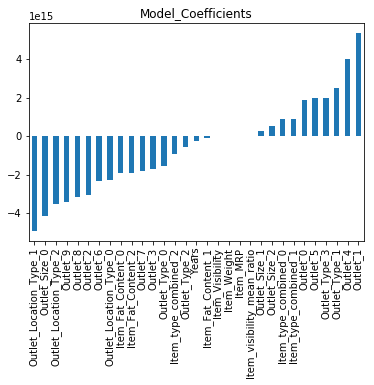

In [26]:
from sklearn.linear_model import LinearRegression,Ridge,Lasso
predictors=[x for x in train.columns if x not in [target]+IDcol]
alg1=LinearRegression(normalize=True)
modelfit(alg1,train,test,predictors,target,IDcol,'alg1.csv')
coef1=pd.Series(alg1.coef_,predictors).sort_values()
coef1.plot.bar(title="Model_Coefficients")


Model Report
RMSE : 1129 
CV Score:Mean - 1130 | Std - 44.6 | Min - 1076 | Max - 1217 |


C:\Users\user\.anaconda\Newfolder\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':


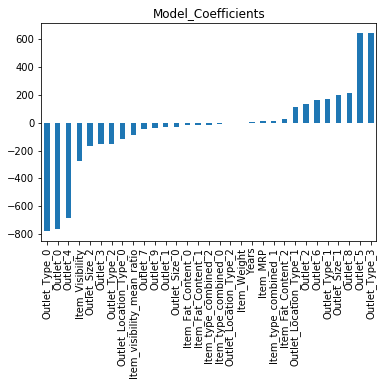

In [27]:
predictors=[x for x in train.columns if x not in [target]+IDcol]
alg2=Ridge(alpha=0.05,normalize=True)
modelfit(alg2,train,test,predictors,target,IDcol,'alg2.csv')
coef2=pd.Series(alg2.coef_,predictors).sort_values()
coef2.plot.bar(title="Model_Coefficients")


Model Report
RMSE : 1058 
CV Score:Mean - 1091 | Std - 45.42 | Min - 1003 | Max - 1186 |


C:\Users\user\.anaconda\Newfolder\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':


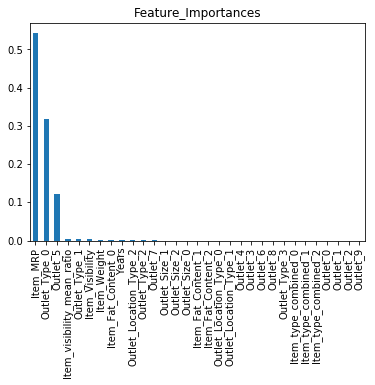

In [28]:
from sklearn.tree import DecisionTreeRegressor
predictors=[x for x in train.columns if x not in [target]+IDcol]
alg3=DecisionTreeRegressor(max_depth=15,min_samples_leaf=100)
modelfit(alg3,train,test,predictors,target,IDcol,'alg3.csv')
coef3=pd.Series(alg3.feature_importances_,predictors).sort_values(ascending=False)
coef3.plot.bar(title="Feature_Importances")


Model Report
RMSE : 1071 
CV Score:Mean - 1096 | Std - 43.3 | Min - 1027 | Max - 1172 |


C:\Users\user\.anaconda\Newfolder\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':


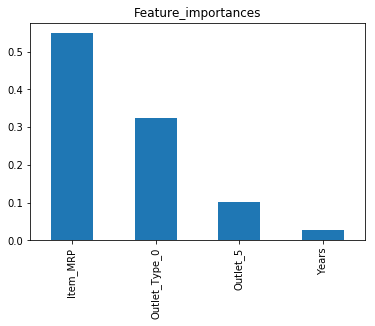

In [29]:
predictors=['Item_MRP','Outlet_Type_0','Outlet_5','Years']
alg4=DecisionTreeRegressor(max_depth=8,min_samples_leaf=150)
modelfit(alg4,train,test,predictors,target,IDcol,'alg4.csv')
coef4=pd.Series(alg4.feature_importances_,predictors).sort_values(ascending=False)
coef4.plot.bar(title='Feature_importances')


Model Report
RMSE : 1073 
CV Score:Mean - 1083 | Std - 43.8 | Min - 1020 | Max - 1162 |


C:\Users\user\.anaconda\Newfolder\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':


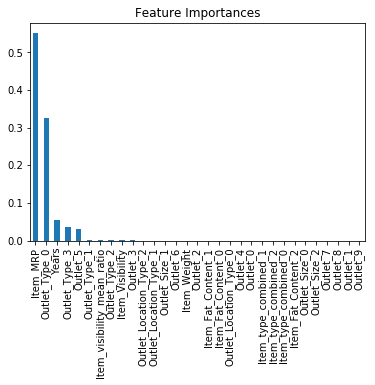

In [30]:
from sklearn.ensemble import RandomForestRegressor
predictors=[x for x in train.columns if x not in [target]+IDcol]
alg5=RandomForestRegressor(n_estimators=200,max_depth=5,min_samples_leaf=100,n_jobs=4)
modelfit(alg5,train,test,predictors,target,IDcol,'alg5.csv')
coef5=pd.Series(alg5.feature_importances_,predictors).sort_values(ascending=False)
coef5.plot(kind='bar' , title='Feature Importances')


Model Report
RMSE : 1068 
CV Score:Mean - 1083 | Std - 43.64 | Min - 1020 | Max - 1161 |


C:\Users\user\.anaconda\Newfolder\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':


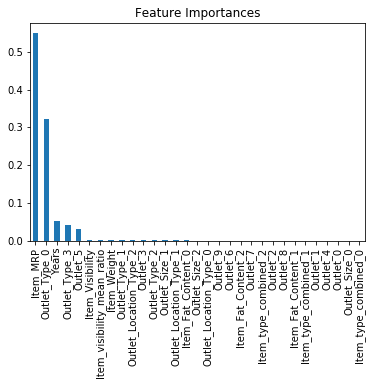

In [31]:
predictors=[x for x in train.columns if x not in [target]+IDcol]
alg6=RandomForestRegressor(n_estimators=400,max_depth=6,min_samples_leaf=100,n_jobs=4)
modelfit(alg6,train,test,predictors,target,IDcol,'alg6.csv')
coef6=pd.Series(alg6.feature_importances_,predictors).sort_values(ascending=False)
coef6.plot.bar(title='Feature Importances')